<a href="https://colab.research.google.com/github/uprestel/Matrix-Completion/blob/master/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compressed Sensing - Matrix completion project

In this project we explore the DRS and FISTA algorithms within the framework of the matrix completion problem.

We apply said algorithms to image inpainting / reconstruction and the Netflix problem.

---



In [33]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # If we are in colab, we download the data from the repository
    !git -C Matrix-Completion pull || git clone https://github.com/uprestel/Matrix-Completion.git
    %cd Matrix-Completion/

fatal: cannot change to 'Matrix-Completion': No such file or directory
Cloning into 'Matrix-Completion'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 137 (delta 27), reused 9 (delta 1), pack-reused 74
Receiving objects: 100% (137/137), 5.87 MiB | 15.58 MiB/s, done.
Resolving deltas: 100% (61/61), done.
/content/Matrix-Completion/Matrix-Completion


## Image inpainting / completion

We start off by applying our algorithms to incomplete images. We do this mainly as a sanity check to see if our algorithms are correct.



In [0]:
import numpy as np
from numpy.linalg import matrix_rank as rank
import matplotlib.pyplot as plt
from PIL import Image
from numpy import asarray
import copy 
import scipy

def lowrank_missing(A, p, k, noise=0.0):
    """
    Generates an image A' where we have the rank k and missing entries.
    The given entries have optional noise.
    
    Input:
        A: the image we wish to corrupt.
        p: the probability that a given entry is missing in the final image.
        k: the rank of the final corrupted image.
        noise: the additive noise factor for our given entries. We assume that 
                our noise satisfies the normal distribution N(0,noise).
    Output:
        mask_rec: matrix of the corrupted image.
        mask: matrix with boolean values that indicates if the correspondent pixel is known
              in the corrupted image.
    """
    m, n = A.shape
    min_dim = min(m,n)
    mask = np.random.choice(np.arange(0,2), p=[p, 1-p], size=(m,n))
    noise_matrix = np.random.normal(loc=0, scale = noise, size=(m,n))
    A_masked = np.multiply(A + noise_matrix,mask)
    U, s, VT = np.linalg.svd(A_masked, full_matrices=True )
    r = rank(A_masked)
    s[min_dim-k:] = 0
    S = np.zeros((m, n), dtype=np.float)
    S[:min_dim, :min_dim] = np.diag(s)
    mask_rec = U@(S@VT)
    
    return (mask_rec, mask)

def shrinkage_threshold(x, alpha):
    """
    Applies the shrinkage/soft-threshold operator given a vector and a threshold.
    It's defined in the equation 1.5 in the paper of FISTA.
    
    Input:
        x: vector to apply the soft-threshold operator.
        alpha: threshold.
    Output:
        x_out: vector after applying the soft-threshold operator.
    """
    x_sgn  = np.sign(x)
    x_plus = np.maximum(np.absolute(x) - alpha, np.zeros_like(x))
    x_out  = np.multiply (x_plus, x_sgn)
    
    return x_out

def singular_value_shrinkage(X, alpha):
    """
    Performs the called singular value shrinkage defined in the equation 2.2 
    in the paper from Candes.
    
    Input:
        X: matrix to apply the singular value shrinkage operator.
        alpha: threshold.
    Output:
        X_out: matrix after applying the singular value shrinkage operator.
    """
    U, s, VT = np.linalg.svd(X, full_matrices=True)
    s_shth = shrinkage_threshold(s, alpha)
    S = np.zeros_like(X)
    np.fill_diagonal(S, s_shth)
    X_out = U@(S@VT)
    
    return X_out

def FISTA(X, omega, alpha, n_iter):
    """
    Performs the Fast Iterative Shrinkage-Thresholding Algorithm (FISTA) defined
    in the paper of FISTA adapted to the problem of matrix completion.
    
    Input:
        X: noisy matrix.
        omega: set of indexes whith the known values of the matrix X.
        alpha: threshold for the singular value shrinkage operator.
        n_iter: Number of iteration that the algorithm executes.
    Output:
        X_k: reconstructed matrix after n_iter iterations of the algorithm.
    """
    X_kminus1 = copy.deepcopy(X)
    Y_k = copy.deepcopy(X)
    t_k = 1
    for k in range(n_iter):
        Y_k[omega] = X[omega]
        X_k = singular_value_shrinkage(Y_k, alpha)
        t_kplus1 = (1 + np.sqrt(1+4*t_k**2))/2
        Y_k = X_k + ((t_k-1)/t_kplus1)*(X_k - X_kminus1)
        X_kminus1 = X_k
        t_k = t_kplus1  
        
    return X_k

def plot_image (image, title, cmap):
    """
    Plots an image given the matrix in a numpy array.
    
    Input:
        X: image embedded in a numpy array.
        title: title of the plot.
        cmap: color map of the image.
    Output:
        None
    """
    plt.matshow(image, cmap=cmap)
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
    return None
    

Shape of original image: (394, 700)


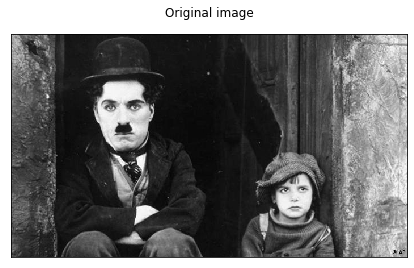

Corrupting the image...


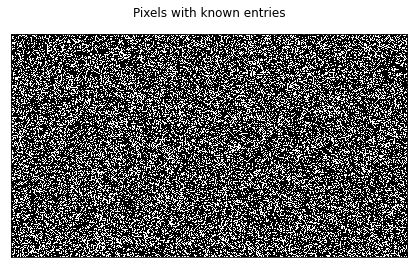

Shape of corrupted image: (394, 700)


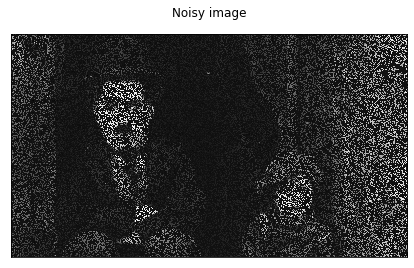

In [55]:
# path of the image
path = "./images/chaplin.jpg"
# load the image
image = Image.open(path).convert('L')
# convert image to numpy array
A = asarray(image)
m, n = A.shape
# sanity check
print("Shape of original image: {}".format(A.shape))
# plot image
plot_image(A, "Original image", "gray")
# define the rank of the final corrupted image 
k = 33
# define the probability that a given entry is missing in the final image
prob = 0.70
# corrupt the image
print ("Corrupting the image...")
A_noisy, mask = lowrank_missing(A, prob, k)
plot_image(mask, "Pixels with known entries", "gray")
# sanity check
print("Shape of corrupted image: {}".format(A_noisy.shape))
plot_image(A_noisy, "Noisy image", "gray")

### Image reconstruction in the noisy case via FISTA

Shape of reconstructed image: (394, 700)


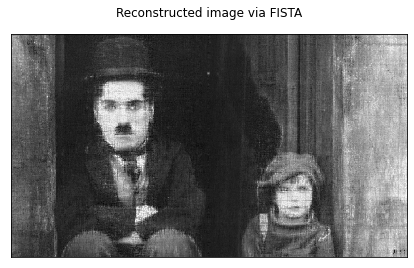

In [56]:
# get the indexes where the observed values are
omega = np.where(mask!=0)
# reconstruct the image via FISTA
X_reconstructed = FISTA(A_noisy, omega, 10, 200)
# sanity check
print ("Shape of reconstructed image: {}".format(X_reconstructed.shape))
# plot image reconstructed
plot_image(X_reconstructed, "Reconstructed image via FISTA", "gray")

### Image reconstruction in the noiseless case via DRS

We are trying to solve the minimization problem $$\min_X ||X||_* \ \ \ s. t. \ \ \ AX = B$$
This can be done via Douglas-Rachford splitting. For a derivation see the report.

$$
\begin{cases}
    x^{(k+1)} = \text{Prox}_f^\gamma (z^{(k)})\\
    g^{(k+1)} = \text{Prox}_g^\gamma (2x^{(k+1)} - z^{(k)})\\
    z^{(k+1)} = z^{(k)} + y^{(k+1)} - x^{(k+1)}
\end{cases}
$$

In [0]:
from scipy.sparse import csc_matrix
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import inv

def D(X, gamma, m, n):
    """
    Applies the singular value thresholding operator given a vector, 
    which contains the matrix entries flattened.
    Input:
        X: unidimensional vector that represents the flattened matrix.
        gamma: threshold.
        m, n: dimensions of the matrix.
    Output:
        Xt: unidimensional vector that represents the flattened matrix after applying the
            singular value shrinkage operator.
    """
    X_ = X.reshape((m,n))
    Xt = singular_value_shrinkage (X_, gamma)
    Xt = Xt.reshape(m*n)
    
    return Xt

def draw(vec, m, n, title="", xlabel="", ylabel=""):
    """
    Plots the image given a flattened vector with the respective entries of the image.
    Input:
        vec: unidimensional vector that represents the flattened matrix.
        m, n: dimensions of the matrix.
    Output:
        None.
    """
    mat = vec.reshape((m,n))
    plt.matshow(mat, cmap="gray")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
    
def draw_mat(mat, title="", xlabel="", ylabel=""):
    """
    Plots the image given a flattened vector with the respective entries of the image.
    Input:
        vec: unidimensional vector that represents the flattened matrix.
        m, n: dimensions of the matrix.
    Output:
        None.
    """
    plt.matshow(mat, cmap="gray")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks([])
    plt.yticks([])
    plt.show()

def flatten(omega, n):
    """
    Transforms the index set omega ( which stores the elements which are nonzero in the corrupted image )
    into a vector-index representation.
    Input:
        omega: index set omega.
        n: second dimension of the matrix.
    Output:
        flattened: representation of the index set omega in one dimension.
    """
    flattened = []
    for coord in omega:
        i,j = coord
        flattened.append(i*n + j)
    
    return flattened
    
def construct_A(omega, m, n):
    """
    Construct the matrix A, that encodes the known entries.
    Input:
        omega: index set omega.
        m, n: dimensions of the matrix.
    Output:
        A: matrix A, that encodes the known entries.
    """
    omega_flat = flatten(omega, n)
    p = len(omega_flat) 
    row = np.arange(p)
    col = omega_flat
    data = np.ones(p)
    A = csc_matrix((data, (row, col)), shape=(p, m*n))
    
    return A

def DRS(A, B, m, n, iterations, gamma):
    """
    Performs the Douglas–Rachford Splitting algorithm.
    Input:
        A: matrix A, that encodes the known entries.
        B: the known entries-vector.
        iteration: number of iterations to perform in the algorithm.
        gamma: threshold.
    Output:
        zk: unidimensional vector with the final approximation.
    """
    zk = np.zeros(m*n)
    for k in range(0, iterations):
        xk = zk + A.T @ (B - A@zk)
        
        yk = D(2*xk - zk, gamma, m, n)
        zk = zk + yk - xk
    
    return zk

B shape :  (82566,)
A shape:  (82566, 275800)


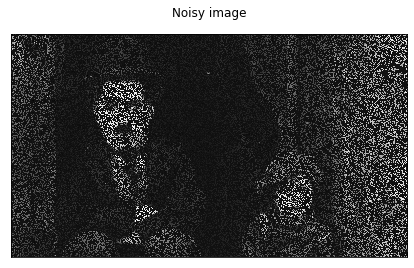

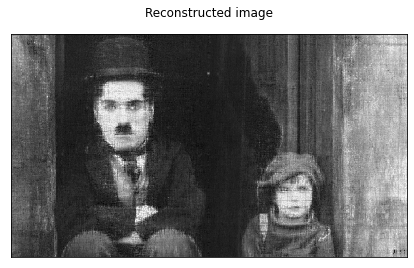

In [58]:
# get the values and the indexes of the known entries
omegaval = np.where(mask!=0)
omega = np.argwhere(mask!=0)
m, n = A_noisy.shape

# define the unidimensional vector B with the known entries
B = A_noisy[omegaval]
# sanity check
print ("B shape : ", B.shape)
# construct the matrix A, that encodes the known entries
A = construct_A(omega, m, n)
# sanity check
print ("A shape: ", A.shape)

# plot the noisy image
draw(A_noisy, m, n, "Noisy image")
# run the DRS algorithm
rec = DRS(A, B, m, n, iterations = 1000, gamma = 20)
# plot the reconstructed image
draw(rec, m, n, "Reconstructed image")

# Netflix problem
Now we apply our algorithms to the netflix problem, i.e. predicting ratings for unrated movies

In [0]:
import os
import tarfile
from scipy.sparse import csc_matrix, coo_matrix, csr_matrix
import numpy as np


def parse_customer_data(chunk):
    """
    Helper function to turn the customer data into usable data.
    Each line in our chunk corresponds to a rating from a customer
    and its date in the following format:
    CustomerID, Rating, Date
    
    returns:
        List of tuples containing the two elements 
        (CustomerID: int, Raring: int)
    """
    
    dat = []
    for cust_rating in chunk.split("\\n"):
        rating_data = cust_rating.split(",")
        if len(rating_data) == 3:
            
            customer_id, rating = map(int, rating_data[:2])
            
            #print(cust_rating, customer_id, rating)
            dat.append((customer_id, rating))
            
    return dat

def get_netflix_matrix(path, movie_id_range, customer_id_range, noise=0.0):
    """
    This generates the sparse netflix matrix, where the entries B_ij are the ratings
    of a movie j of customer i.
    
    Since the matrix is very big, we can specify a range of possible movie and customer
    values.
    
    Input:
        path: the path leading to the netflix .tar training file
        movie_id_range: a 2-tuple with min and max values for the movie id
              Movie ids range from 1 to 17770 sequentially
        customer_id_range: a 2-tuple with min and max values for the customer id
              CustomerIDs range from 1 to 2649429, with gaps. There are 480189 users
    Output:
        B: the netflix matrix in sparse form (scipy.csc_matrix)
        mask: matrix with boolean values that indicates if the corresponding entry is known
              in the corrupted image (scipy.csc_matrix)
        customer_id_mapping: The mapping which maps a true user id to some smaller id.
              This mapping is necessary if the true user id needs to be recovered later.
    """
    
    assert 1 <= movie_id_range[0] and movie_id_range[1] <= 17770
    assert 1 <= customer_id_range[0] and customer_id_range[1] <= 2649429
    
    # since there are gaps in the user ids, we want to eliminate the gaps by
    # mapping these ids to a new range 1...480189
    customer_id_mapping = {}
    n_customer_ids = 0
    
    with tarfile.open(data_path) as tf:

        row = []
        col = []
        ratings = []

        for entry in tf:
            fileobj = tf.extractfile(entry)

            if fileobj is not None:
                data = str(fileobj.read())
                movie_id, customer_data = data.split(":")
                #print(entry)
                movie_id = int(movie_id[2:])
                customer_data = parse_customer_data(customer_data)

                #print(movie_id, customer_data)
                for customer_ in customer_data:
                    customer_id, customer_rating = int(customer_[0]), int(customer_[1])

                    if customer_id_range[0] <= customer_id <= customer_id_range[1] and movie_id_range[0] <= movie_id <= movie_id_range[1]:
                        if not customer_id in customer_id_mapping.keys():
                            customer_id_mapping[customer_id] = n_customer_ids
                            n_customer_ids += 1
                        
                        ratings.append(customer_rating)
                        col.append(customer_id_mapping[customer_id])
                        row.append(movie_id)
                        
        B = csr_matrix((ratings, (row, col)))
        mask = (B!=0)
        return B, mask, customer_id_mapping

In [60]:
if not IN_COLAB:    
    notebook_path = os.getcwd()
    data_path = os.path.join(notebook_path, "download/training_set.tar")

    # To make the optimization a bit more feasible, we restrict our matrix size,
    # we restrict ourselves to a range of MovieIDs and CustomerIDs

    movie_id_range = (200, 1200)
    customer_id_range = (2000, int(2649429./700))

    B_sparse, mask, customer_id_mapping = get_netflix_matrix(data_path, movie_id_range, customer_id_range)


    print("done")
else:
    !ls
    B_sparse=scipy.sparse.load_npz('netflix_matrix.npz')
    mask = (B_sparse!=0)

images		    project.ipynb  report.aux  report.pdf	  report.tex
netflix_matrix.npz  README.md	   report.log  report.synctex.gz


In [0]:
#import scipy
#scipy.sparse.save_npz('./netflix_matrix.npz', B_sparse)

(1201, 265)
B shape :  (3459,)
A shape:  (3459, 318265)


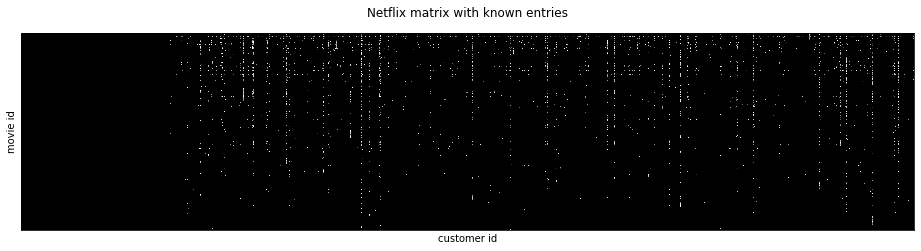

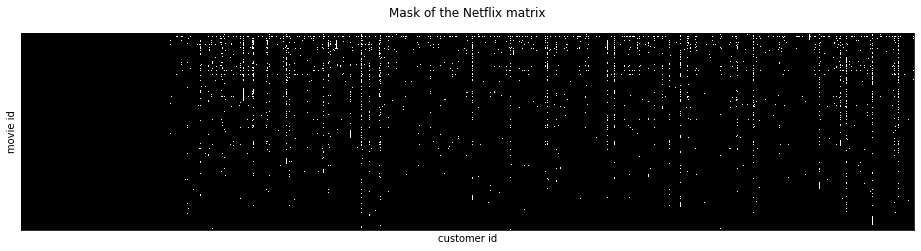

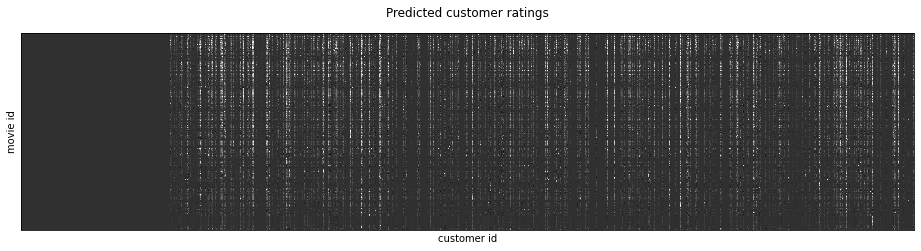

In [61]:
# get the values and the indexes of the known entries
B_dense = B_sparse.toarray()
print(B_dense.shape)
mask_dense = (B_dense !=0)
omegaval = np.where(mask_dense!=0)
omega = np.argwhere(mask_dense!=0)
m, n = B_dense.shape

# define the unidimensional vector B with the known entries
B = np.squeeze(np.asarray(B_dense[omegaval]))
# sanity check
print ("B shape : ", B.shape)
# construct the matrix A, that encodes the known entries
A = construct_A(omega, m, n)
# sanity check
print ("A shape: ", A.shape)

# plot the noisy image
draw_mat(B_dense.T, "Netflix matrix with known entries", ylabel="movie id", xlabel="customer id")
draw_mat(mask_dense.T, "Mask of the Netflix matrix", ylabel="movie id", xlabel="customer id")
# run the DRS algorithm
rec = DRS(A, B, m, n, iterations = 200, gamma = .75).reshape(m, n)
# plot the reconstructed image
draw_mat(rec.T,"Predicted customer ratings", ylabel="movie id", xlabel="customer id")

### Bonus -- validation of the predictions & hyperparameter tuning
What we can do now is to validate the predicted ratings by selecting a few random known entries form our netflix matrix and moving them to a validation set. We can then try to see how well the predicted recommendation matches with the validation set.

Using this method we can tune the parameters of DRS and FISTA using a grid-seach.

In [0]:
def training_validaton_split(B, omega, validation_size):
    """
    splits the available data into a training and a validation set. Concretely this means that
    we take randomly selected known ratings from the netflix matrix and put them into our validation set
    
    Input:
        B: the constructed netflix matrix.
        omega: the index set of known entries in B.
        validation_size: the size of the validation set, i.e. how many known ratings we want to select.
        
    Output:
        B_train: the netflix matrix without the randomly selected entries.
        validation_ratings: a list of tuples of the form (customer_id, movie_id, rating)
        omega_train: the omega set where B_train is nonzero.
    """
    
    B_train = copy.deepcopy(B)
    validation_ratings = []
    
    rints = np.random.randint(omega.shape[0], size=validation_size)
    indices = omega[rints]    

    for i in range(validation_size):
        customer_id, movie_id = indices[i]
        rating = B[customer_id, movie_id]
        validation_ratings.append((customer_id, movie_id, rating))
        
        B_train[customer_id, movie_id] = 0
        
    omega_train = np.delete(omega, rints, axis=0)
    return B_train, validation_ratings, omega_train


def get_loss(rec, validation_ratings):
    """
    calculate the mean error between the predicted and the true ratings
    """
    loss = 0.0
    for customer_id, movie_id, rating in validation_ratings:
        predicted_rating = rec[customer_id, movie_id]
        loss += np.abs(predicted_rating - rating)
    return loss/len(validation_ratings)

Now we can split up our known entires into a training and validation set and see how well the prediction aligns with the ground truth

In [114]:
B_train, validation_ratings, omega_train = training_validaton_split(B_dense, omega, validation_size=100)
A = construct_A(omega_train, m, n)
mask_train = (B_train!=0)
omegaval_train = np.where(mask_train!=0)
B = B_train[omegaval_train]
rec = DRS(A, B, m, n, iterations = 200, gamma = 1.9).reshape(m, n)

# now we get the recommendations
for customer_id, movie_id, rating in validation_ratings:
    predicted_rating = rec[customer_id, movie_id]
    print("predicted: ", max(0, min(5, round(predicted_rating))), "ground truth: ", rating)

predicted:  1.0 ground truth:  3
predicted:  5 ground truth:  3
predicted:  3.0 ground truth:  3
predicted:  2.0 ground truth:  5
predicted:  2.0 ground truth:  1
predicted:  2.0 ground truth:  2
predicted:  2.0 ground truth:  4
predicted:  0 ground truth:  2
predicted:  2.0 ground truth:  4
predicted:  0 ground truth:  5
predicted:  3.0 ground truth:  3
predicted:  2.0 ground truth:  3
predicted:  4.0 ground truth:  5
predicted:  2.0 ground truth:  3
predicted:  0 ground truth:  4
predicted:  2.0 ground truth:  2
predicted:  3.0 ground truth:  4
predicted:  2.0 ground truth:  3
predicted:  2.0 ground truth:  4
predicted:  3.0 ground truth:  2
predicted:  4.0 ground truth:  5
predicted:  0 ground truth:  1
predicted:  0 ground truth:  4
predicted:  2.0 ground truth:  3
predicted:  4.0 ground truth:  2
predicted:  3.0 ground truth:  4
predicted:  3.0 ground truth:  3
predicted:  1.0 ground truth:  2
predicted:  3.0 ground truth:  5
predicted:  3.0 ground truth:  4
predicted:  2.0 ground

### Hyperparameter tuning

In [110]:
# we consider a range of possible hyperparameters

def grid_search_DRS(parameters, validation_size, considered_splits):
    """
    perform a grid search for DRS to obtain the optimal hyperparameters.

    To get a better estimate of the loss, we consider many possible splits
    (i.e. considered_splits) and calculate the mean loss.

    We then select the parameter which yields the smallest mean loss.

    Input:
        parameters: the numpy array of possible parameters
        validation_size: how many known entries we select from the netflix matrix
        considered_splits: how many such splits we actually consider.
    Output:
        best_param: the parameter which yields the lowest mean loss.
    """
    
    best_param = parameters[0]
    best_loss = 1e10
    
    for param in parameters:
        
        mean_loss = 0.0
        for _ in range(considered_splits):
            B_train, validation_ratings, omega_train = training_validaton_split(B_dense, omega, validation_size=100)
            A = construct_A(omega_train, m, n)
            mask_train = (B_train!=0)
            omegaval_train = np.where(mask_train!=0)
            B = B_train[omegaval_train]

            rec = DRS(A, B, m, n, iterations = 100, gamma = param).reshape(m, n)
            mean_loss += get_loss(rec, validation_ratings)

        mean_loss /= considered_splits
        if mean_loss < best_loss:
            best_param = param
            best_loss = mean_loss
        print("current parameter: ", param, "with mean loss: ", mean_loss, "vs best parameter: ",best_param, "with best mean loss: ", best_loss)
    return best_param


parameters = np.arange(0,2,.1)
print("grid:", parameters)
print("best parameter in grid: ", grid_search_DRS(parameters, validation_size=100, considered_splits=3))


grid: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9]
current parameter:  0.0 with mean loss:  3.463333333333324 vs best parameter:  0.0 with best mean loss:  3.463333333333324
current parameter:  0.1 with mean loss:  3.2120215059048536 vs best parameter:  0.1 with best mean loss:  3.2120215059048536
current parameter:  0.2 with mean loss:  3.173042233597441 vs best parameter:  0.2 with best mean loss:  3.173042233597441
current parameter:  0.30000000000000004 with mean loss:  2.870076631613342 vs best parameter:  0.30000000000000004 with best mean loss:  2.870076631613342
current parameter:  0.4 with mean loss:  2.60357214754514 vs best parameter:  0.4 with best mean loss:  2.60357214754514
current parameter:  0.5 with mean loss:  2.543733986155394 vs best parameter:  0.5 with best mean loss:  2.543733986155394
current parameter:  0.6000000000000001 with mean loss:  2.479749925014476 vs best parameter:  0.6000000000000001 with best mean loss:  2.4797